# Imports

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

-----

- Remove Leap day, set date to index, make subsctiprion type int.
- Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
- Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you

# Wrangle the Data.

In [71]:
#acquiring the dataset
df = pd.read_csv('saas.csv')

In [72]:
#790458 records x 5 fields.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [73]:
df.head(5)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [74]:
df.describe()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [75]:
#added in column in datetime format which 
df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced).sort_values()

In [76]:
df.head(5)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [77]:
df = df.set_index('Month_Invoiced').sort_index()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Customer_Id        790458 non-null  int64  
 1   Invoice_Id         790458 non-null  int64  
 2   Subscription_Type  790458 non-null  float64
 3   Amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


In [79]:
df.head(5)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [80]:
# subscription_type to int.
df['Subscription_Type']= df.Subscription_Type.astype('int')
# subscription_type to int.
df['Amount']= df.Amount.astype('int')

In [81]:
df_resampled = df.resample('M')['Amount'].sum()

<AxesSubplot:xlabel='Month_Invoiced'>

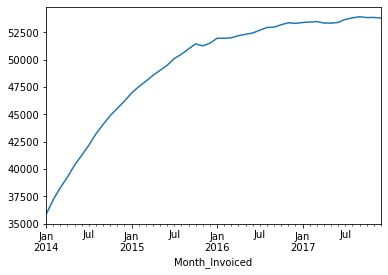

In [82]:
df_resampled.plot()

#### Prepare Function

In [83]:

def prep_data(df):
    '''
    The function takes in a dataframe and returns a dataframe with 
    the dates as index, aggregated by summing at the daily level,
    changing the sale_amount column namme to be items_sold, 
    creating a new feature of dollars_sold (sale_amount * item_price)
    and removing the leap day. 
    '''
    # convert sale_date to datetime format
    df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced)
    
    # sort values by date
    df = df.sort_values('Month_Invoiced')
    
    # set index
    df = df.set_index('Month_Invoiced')
    
    # subscription_type to int.
    df['Subscription_Type']= df.Subscription_Type.astype('int')
    # subscription_type to int.
    df['Amount']= df.Amount.astype('int')
    
    
    # aggregate or resample daily by summing Amount
    df_resampled = df.resample('M')[['Amount']].sum()

    # remove leap day
    df_resampled = df_resampled[df_resampled.index != '2016-02-29']
    
    return df_resampled

In [84]:
df = pd.read_csv('saas.csv')

In [85]:
df = prep_data(df)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2014-01-31 to 2017-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Amount  47 non-null     int64
dtypes: int64(1)
memory usage: 752.0 bytes


------

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [87]:
# set train size to be 50% of total 
train_size = int(len(df) * 0.5)
train_size 

23

In [88]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size

14

In [89]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

10

In [90]:
validate_end_index = train_size + validate_size
validate_end_index

37

In [91]:
# train will go from 0 to 23
train = df[:train_size]
# validate will go from 23 to 37
validate = df[train_size:validate_end_index]
# test will include 37 to 47
test = df[validate_end_index:]

------

#### **Verify Splits**

Does the length of each df equate to the length of the original df? 

Have to make sure train + validate + test == length origin df

In [92]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


#### Does the first row of original df equate to the first row of train? 

In [93]:
print(df.head(1) == train.head(1))

                Amount
Month_Invoiced        
2014-01-31        True


<AxesSubplot:xlabel='Month_Invoiced'>

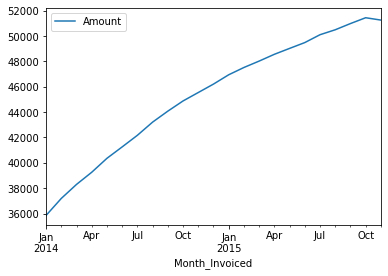

In [94]:
train.plot()

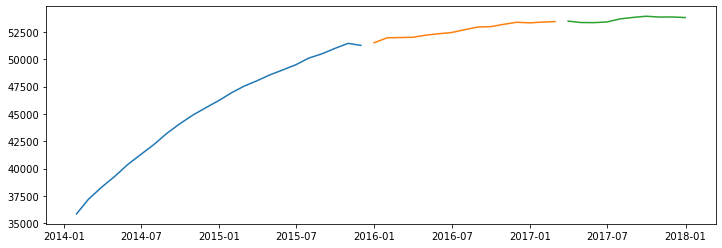

In [95]:

plt.figure(figsize=(12,4))
plt.plot(train)
plt.plot(validate)
plt.plot(test)


In [96]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [97]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [98]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [99]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Amount

In [100]:
train.head()

,Amount
Month_Invoiced,
2014-01-31,35850
2014-02-28,37190
2014-03-31,38295
2014-04-30,39255
2014-05-31,40355


In [101]:
# take the last item of dollars sold and assign to variable
Amount = round(train['Amount'][-1:][0], 2)
Amount

51260

In [102]:
yhat_df = pd.DataFrame({'Amount': [Amount]}, 
                      index = validate.index)

yhat_df.head()

,Amount
Month_Invoiced,
2015-12-31,51260
2016-01-31,51260
2016-03-31,51260
2016-04-30,51260
2016-05-31,51260


In [103]:
yhat_df.describe()

,Amount
count,14.0
mean,51260.0
std,0.0
min,51260.0
25%,51260.0
50%,51260.0
75%,51260.0
max,51260.0


------

You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

Amount -- RMSE: 1559


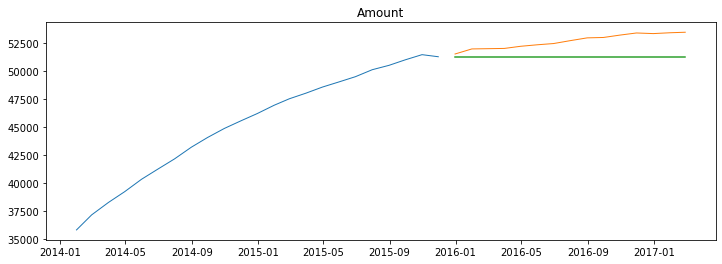

In [104]:
plot_and_eval('Amount')

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [105]:

for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1559.0


### Simple Average


**Make Predictions**

Avg_temp: establishing the value of the prediction we will make

In [106]:
# compute simple average
temp = round(train['Amount'].mean(), 4)
temp

45310.4348

In [107]:
def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [temp],
                           },
                          index=validate.index)
    return yhat_df

In [108]:
yhat_df = make_predictions()

In [109]:
yhat_df.head()

,Amount
Month_Invoiced,
2015-12-31,45310.4348
2016-01-31,45310.4348
2016-03-31,45310.4348
2016-04-30,45310.4348
2016-05-31,45310.4348


In [110]:
yhat_df.describe()

,Amount
count,14.0000
mean,45310.4348
std,0.0000
min,45310.4348
25%,45310.4348
50%,45310.4348
75%,45310.4348
max,45310.4348


Amount -- RMSE: 7410


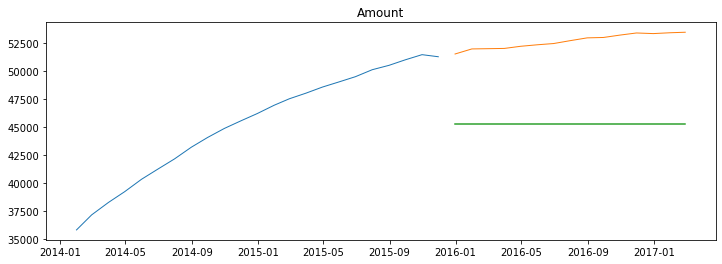

In [111]:
for col in train:
    plot_and_eval('Amount')

#### **Evaluate**

Evaluate using MSE and RMSE

In [112]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1559.0
1,simple_average,Amount,7410.0


------

### Moving Average



In [113]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['Amount'].rolling(30).mean())


Month_Invoiced
2014-01-31   NaN
2014-02-28   NaN
2014-03-31   NaN
2014-04-30   NaN
2014-05-31   NaN
2014-06-30   NaN
2014-07-31   NaN
2014-08-31   NaN
2014-09-30   NaN
2014-10-31   NaN
2014-11-30   NaN
2014-12-31   NaN
2015-01-31   NaN
2015-02-28   NaN
2015-03-31   NaN
2015-04-30   NaN
2015-05-31   NaN
2015-06-30   NaN
2015-07-31   NaN
2015-08-31   NaN
2015-09-30   NaN
2015-10-31   NaN
2015-11-30   NaN
Name: Amount, dtype: float64


#### **Predictions**

In [114]:
period = 30

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
amount = round(train['Amount'].rolling(period).mean()[-1], 2)
print(amount)

nan


In [115]:
yhat_df = make_predictions()
yhat_df.head()

,Amount
Month_Invoiced,
2015-12-31,45310.4348
2016-01-31,45310.4348
2016-03-31,45310.4348
2016-04-30,45310.4348
2016-05-31,45310.4348


#### **Plot Actual vs. Predicted Values**

**Moving Average**

Amount -- RMSE: 7410


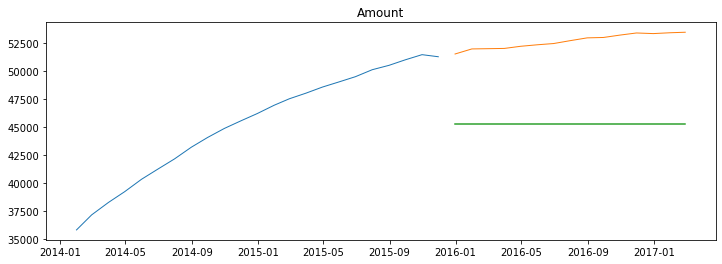

In [116]:
for col in train.columns:
    plot_and_eval(col)

#### **Evaluate**

Evaluate using MSE and RMSE.

In [117]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1559.0
1,simple_average,Amount,7410.0
2,30d_moving_avg,Amount,7410.0


In [118]:
#will look at rolling averages for 10, 30 and 45 days
periods = [10, 45, 60]

for p in periods: 
    avg_temp = round(train['Amount'].rolling(p).mean()[-1], 6)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [119]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1559.0
1,simple_average,Amount,7410.0
2,30d_moving_avg,Amount,7410.0
3,10d_moving_avg,Amount,7410.0
4,45d_moving_avg,Amount,7410.0
5,60d_moving_avg,Amount,7410.0


In [120]:
#comparison of different time period rmse values
min_avg_temp_rmse = eval_df[eval_df.target_var == 'avg_temp']['rmse'].min()

eval_df[eval_df.rmse == min_avg_temp_rmse]

,model_type,target_var,rmse


### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

Amount 



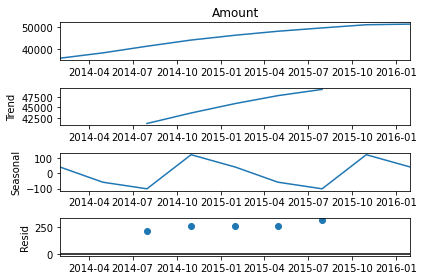

In [121]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
plt.show()

### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [122]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [123]:
col = 'Amount'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 4)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [124]:
yhat_df.head(50)

,Amount
Month_Invoiced,
2015-12-31,51853.2579
2016-01-31,52169.0152
2016-03-31,52776.5618
2016-04-30,53068.7571
2016-05-31,53353.4959
2016-06-30,53630.9684
2016-07-31,53901.3600
2016-08-31,54164.8515
2016-09-30,54421.6188


#### **Plot Actual vs. Predicted Values**

Amount -- RMSE: 1354


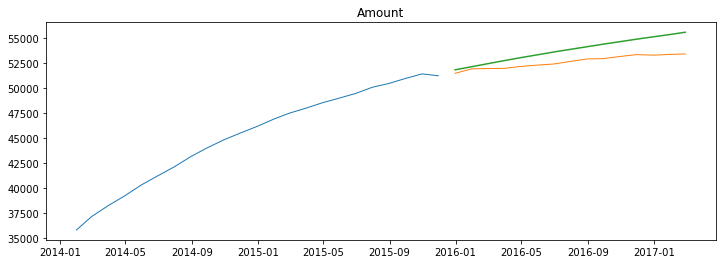

In [125]:
#plotting holt model
for col in train.columns:
    plot_and_eval(target_var = col)

#### **Evaluate**

In [126]:
#adding holt to df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [127]:
#sort by rmse to compare values
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
6,holts_optimized,Amount,1354.0
0,last_observed_value,Amount,1559.0
1,simple_average,Amount,7410.0
2,30d_moving_avg,Amount,7410.0
3,10d_moving_avg,Amount,7410.0
4,45d_moving_avg,Amount,7410.0
5,60d_moving_avg,Amount,7410.0


#### Changing hyperparameters. 


In [128]:
#changing hyperparameter to .1
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope=0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 4)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


Amount -- RMSE: 8850


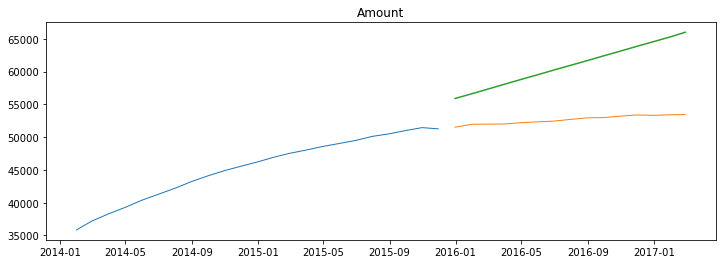

In [129]:
#plotting holt_.1
for col in train.columns:
    plot_and_eval(target_var = col)

In [130]:
#comparing model rmse values
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
6,holts_optimized,Amount,1354.0
0,last_observed_value,Amount,1559.0
1,simple_average,Amount,7410.0
2,30d_moving_avg,Amount,7410.0
3,10d_moving_avg,Amount,7410.0
4,45d_moving_avg,Amount,7410.0
5,60d_moving_avg,Amount,7410.0
7,holts_.1,Amount,8850.0


In [131]:
#Predict on previous cycle

In [133]:
#train is temp 2014 prior
train = df[:'2014']
#validate is 2015 avg temps
validate = df['2015']
#test is 2016 avg temps
test = df['2016']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(12, 1)
(12, 1)
(11, 1)


,Amount
Month_Invoiced,
2014-08-31,43210
2014-09-30,44075
2014-10-31,44880
2014-11-30,45545
2014-12-31,46210


#### **Make Predictions**

In [135]:
# finding the year-over-year difference 
yhat_df = round(train['2014'] + train.diff(1).mean(),2)

In [136]:
#prediction 
pd.concat([yhat_df.head(1), validate.head(1)])

,Amount
Month_Invoiced,
2014-01-31,36791.82
2015-01-31,46945.00


In [137]:
yhat_df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31'],
              dtype='datetime64[ns]', name='Month_Invoiced', freq=None)

In [138]:
validate.index

DatetimeIndex(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31'],
              dtype='datetime64[ns]', name='Month_Invoiced', freq=None)

In [139]:
validate.head()

,Amount
Month_Invoiced,
2015-01-31,46945
2015-02-28,47520
2015-03-31,48025
2015-04-30,48560
2015-05-31,49025


In [140]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [141]:
yhat_df.describe()

,Amount
count,12.000000
mean,42465.986667
std,3399.850821
min,36791.820000
25%,39956.820000
50%,42654.320000
75%,45218.070000
max,47151.820000


In [142]:
yhat_df.head()

,Amount
Month_Invoiced,
2015-01-31,36791.82
2015-02-28,38131.82
2015-03-31,39236.82
2015-04-30,40196.82
2015-05-31,41296.82


In [143]:
yhat_df.shape

(12, 1)

#### **Plot and Evaluate**

Amount -- RMSE: 7356


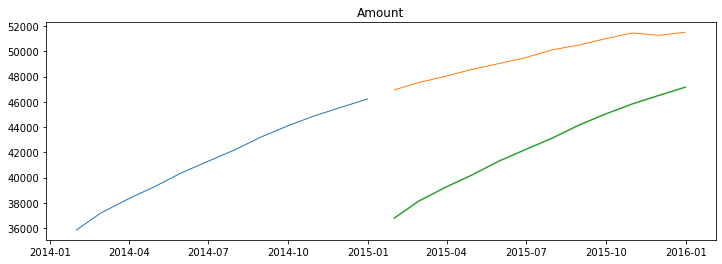

In [144]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

--------

# Conclusion

In [145]:
avg_temp_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]


# find which model that is
eval_df[((eval_df.rmse == avg_temp_min_rmse))]

,model_type,target_var,rmse
6,holts_optimized,Amount,1354.0


In [151]:
yhat_df = validate + train.diff(1).mean()
yhat_df.index = test.index

ValueError: Length mismatch: Expected axis has 12 elements, new values have 11 elements

In [147]:
rmse_temp = round(sqrt(mean_squared_error(test['Amount'], yhat_df['Amount'])), 0)


ValueError: Found input variables with inconsistent numbers of samples: [11, 12]

In [152]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

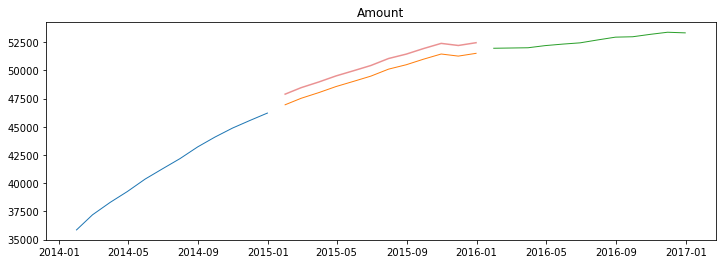

In [153]:
for col in train.columns:
    plot_and_eval(col)

#### Main Takeaways:

#### - The cycle model is the best

----

# Predicting to 2018

In [157]:
#want to predict to 2015 setting prediction
yhat_df = test + train.diff(4).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [158]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

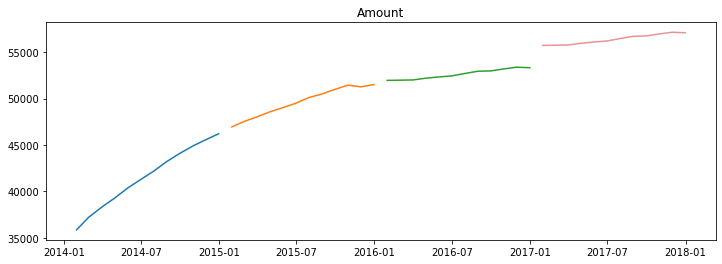

In [159]:
for col in train.columns:
    final_plot(col)